## Analysis of Turbofan Engine Degradation Simulation Data Set
https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan

## Task
* estimate remaining useful life (RUL) with the observed time-series data of sensors

###### reference
https://www.sciencedirect.com/science/article/pii/S0951832018307506

The points of the reference are:
1. adoption of Genetic Algorithm (GA) for hyper parameter tunings of model
1. use of Deep Belief Network (DBN) for semi-supervised learning

## Contents
1. inspection of data
1. prediction with simple model
1. feature engineering
1. prediction with sophisticated models
1. hyper-parameter tuning
1. semi-supervised learning
1. summary

### 1. inspection of data
**load libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import sklearn
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('bmh')
matplotlib.rcParams['font.family'] = 'IPAexGothic'

**check library versions**

In [2]:
import sys
print(sys.version_info)
print(np.__version__)
print(pd.__version__)
print(sns.__version__)
print(scipy.__version__)
print(sklearn.__version__)
print(matplotlib.__version__)

sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
1.18.1
1.0.1
0.10.0
1.4.1
0.22.2
3.1.3


#### load training and test data set

In [3]:
def read_data(path):
  df = pd.read_csv(path, delimiter=' ', header=None)
  # check null ratios of each columns
  rc = df.isnull().sum(axis=0)/len(df)
  print(rc[rc!=0.])
  return df

# read training set
df_train = read_data('CMAPSSData/train_FD001.txt')

26    1.0
27    1.0
dtype: float64


In [4]:
# columns 26 and 27 are all null
df_train.drop([26, 27], axis=1, inplace=True)

# assign proper column names
names = ['unit', 'time',
         'os1', 'os2', 'os3',
         'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr',
         'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']
df_train.columns = names

In [5]:
# read test set
df_test = read_data('CMAPSSData/test_FD001.txt')
df_test.drop([26, 27], axis=1, inplace=True)
df_test.columns = names

26    1.0
27    1.0
dtype: float64


In [6]:
## sanity check
set((df_test.dtypes == df_train.dtypes).tolist())

{True}

#### visual inspection of variables

In [22]:
## dump plots to pdf file
def inspect_variables(df, unit=None, pdf=None):
  names = df.columns
  nrow = 2
  ncol = 3
  fig, axes = plt.subplots(nrow, ncol, constrained_layout=True)
  for ii in range(ncol):
    axes[0,ii].plot(df[names[ii+2]][df.unit==unit], marker='o', markersize=1, linewidth=0)
    axes[0,ii].set_xlabel('time vs {}'.format(names[ii+2]), fontsize=8)
    axes[1,ii].hist(df[names[ii+2]][df.unit==unit], bins=20)
    axes[1,ii].set_xlabel('{} (histogram)'.format(names[ii+2]), fontsize=8)
  fig.suptitle('unit = {}: operational settings'.format(unit))
  pdf.savefig()
  plt.close()

  nrow = 5
  ncol = 5
  idx = 0
  fig, axes = plt.subplots(5, ncol, constrained_layout=True)
  for ii in range(nrow):
    for jj in range(ncol):
      idx = ii*5+jj+5
      axes[ii,jj].plot(df[names[idx]][df.unit==unit], marker='o', markersize=1, linewidth=0)
      axes[ii,jj].set_xlabel('{}'.format(names[idx]), fontsize=8)
      if idx==25: break
  fig.suptitle('unit = {}: sensor readings as time series'.format(unit))
  pdf.savefig()
  plt.close()

  fig, axes = plt.subplots(5, ncol, constrained_layout=True)
  for ii in range(nrow):
    for jj in range(ncol):
      idx = ii*5+jj+5
      axes[ii,jj].hist(df[names[idx]][df.unit==unit], bins=20)
      axes[ii,jj].set_xlabel('{}'.format(names[idx]), fontsize=8)
      if idx==25: break
  fig.suptitle('unit = {}: sensor readings as histogram'.format(unit))
  pdf.savefig()
  plt.close()


from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('plots.pdf') as pdf:
  for unit in range(1,101):
    inspect_variables(df_train, unit=unit, pdf=pdf)

#### add RUL column to training and test data

In [7]:
## set RUL for training set
rul = pd.DataFrame(df_train.groupby('unit')['time'].max())
rul.reset_index(inplace=True)
rul.columns = ['unit', 'time_last']
# sanity check
print(rul[rul.unit==1]['time_last'].to_numpy()[0] == df_train[df_train.unit==1]['time'].max())

train = pd.merge(df_train, rul, on='unit') 
train['rul'] = train['time_last'] - train['time']
train[train.unit==1][['rul', 'time_last', 'time']]  
train.drop(['time_last'], axis=1, inplace=True)

True


In [8]:
## set RUL for test
rul = pd.DataFrame(df_test.groupby('unit')['time'].max())
rul.reset_index(inplace=True)
rul.columns = ['unit', 'time_last']

df_rul = pd.read_csv('CMAPSSData/RUL_FD001.txt', delimiter=' ', header=None)
rul.time_last = rul.time_last + df_rul[0]

test = pd.merge(df_test, rul, on='unit') 
test['rul'] = test['time_last'] - test['time']
test[test.unit==1][['rul', 'time_last', 'time']]  
test.drop(['time_last'], axis=1, inplace=True)

#### check correlations of variables

rul          1.000000e+00
phi          6.719831e-01
P30          6.572227e-01
W32          6.356620e-01
W31          6.294285e-01
P2           1.561885e-14
T2           1.535649e-14
epr          1.414118e-14
farB        -3.799205e-15
os2         -1.947628e-03
os1         -3.198458e-03
P15         -1.283484e-01
NRc         -3.067689e-01
Nc          -3.901016e-01
NRf         -5.625688e-01
Nf          -5.639684e-01
T30         -5.845204e-01
htBleed     -6.061536e-01
T24         -6.064840e-01
BPR         -6.426670e-01
T50         -6.789482e-01
Ps30        -6.962281e-01
os3                   NaN
Nf_dmd                NaN
PCNfR_dmd             NaN
Name: rul, dtype: float64


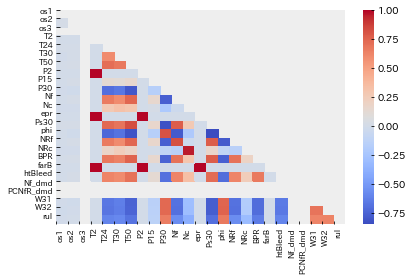

In [9]:
corr = train.drop(['unit', 'time'], axis=1).corr()
print(corr['rul'].sort_values(ascending=False))

plt.figure()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=False, cmap='coolwarm')
plt.xticks(ticks=np.arange(len(corr.columns)), labels=corr.columns, fontsize=8, ha='left')
plt.yticks(ticks=np.arange(len(corr.columns)), labels=corr.columns, fontsize=8, ha='right')
plt.tight_layout()

#### Variables with strong [|var| > 0.5] correlations

**positive**
: **phi** (Ratio of fuel flow to Ps30), **P30** (Total pressure at HPC outlet), **W32** (LPT coolant bleed), **W31** (HPT coolant bleed)

**negative**
: **Ps30** (Static pressure at HPC outlet), **T50** (Total temperature at LPT outlet), **BPR** (Bypass Ratio), **T24** (Total temperature at LPC outlet), **htBleed** (Bleed Enthalpy), **T30** (Total temperature at HPC outlet), **Nf** (Physical fan speed), **NRf** (Corrected fan speed)

HPC: High-Pressure Compressor

HPT: High-Pressure Turbine

LPC: Low-Pressure Compressor

LPT: Low-Pressure Turbine

#### split training data set to training [80%] and validation [20%] set

In [10]:
def get_train_val(df):
  units = df.unit.unique()
  np.random.seed(0)
  unit_train = np.random.choice(units, int(len(units)*0.8), replace=False)
  unit_test = np.array(list(set(units) - set(unit_train)))

  x_train = df[df.unit==unit_train[0]]
  y_train = df.rul[df.unit==unit_train[0]]
  for unit in unit_train[1:]:
    x_train = pd.concat([x_train, df[df.unit==unit]])
    y_train = pd.concat([y_train, df.rul[df.unit==unit]])

  x_val = df[df.unit==unit_test[0]]
  y_val = df.rul[df.unit==unit_test[0]]
  for unit in unit_test[1:]:
    x_val = pd.concat([x_val, df[df.unit==unit]])
    y_val = pd.concat([y_val, df.rul[df.unit==unit]])

  x_train.drop(['unit', 'time', 'rul'], axis=1, inplace=True)
  x_val.drop(['unit', 'time', 'rul'], axis=1, inplace=True)

  return x_train, x_val, y_train, y_val

In [11]:
x_train, x_val, y_train, y_val = get_train_val(train)

### 2. prediction with simple model
#### Linear regression

Text(0, 0.5, 'RUL')

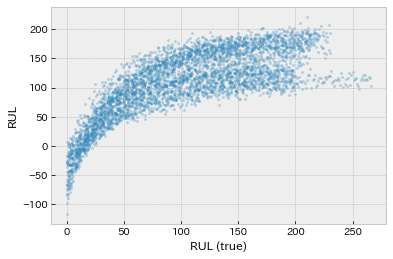

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score

reg_lin = LinearRegression()
reg_lin.fit(x_train, y_train)

predictions = reg_lin.predict(x_val)
plt.figure()
plt.scatter(y_val, predictions, s=5, alpha=0.3)
plt.xlabel('RUL (true)')
plt.ylabel('RUL')

unphysical values (RUL < 0) should be avoided

In [55]:
predictions[predictions <= 0] = 1

**evaluate the model with some metrics**

In [56]:
print(mean_squared_error(y_val, predictions))
print(explained_variance_score(y_val, predictions))
print(r2_score(y_val, predictions))

1581.599864743243
0.5867939304253676
0.5798709902129688


**check residuals**

In [57]:
def plot_residual(preds, scatter=False, ref_true=True):
  hist = None
  if ref_true:
    hist = scipy.stats.binned_statistic(preds.true, [preds.residuals, preds.residuals*preds.residuals], bins=20, statistic='mean')
  else:
    hist = scipy.stats.binned_statistic(preds.preds, [preds.residuals, preds.residuals*preds.residuals], bins=20, statistic='mean')
  means, means2 = hist.statistic
  standard_deviations = np.sqrt(means2 - means*means)
  bin_edges = hist.bin_edges
  bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.

  fig, axes = plt.subplots(nrows=2, ncols=1)

  preds.plot(x="true", y="preds", kind="scatter", alpha=0.2, s=3, ax=axes[0])
  axes[0].set_ylabel('predictions')
  if scatter:
    if ref_true:
      preds.plot(x="true", y="residuals", kind="scatter", alpha=0.2, s=3, ax=axes[1])
    else:
      preds.plot(x="preds", y="residuals", kind="scatter", alpha=0.2, s=3, ax=axes[1])
    axes[1].errorbar(x=bin_centers, y=means, yerr=standard_deviations, color='red', linestyle='none',
                     marker='o', markersize=8, linewidth=1, capsize=3, alpha=0.5, label='$\mu\pm 1\sigma$ spread')
  else:
    if ref=='true':
      preds['preds_binned'] = pd.cut(preds.true, bins=hist.bin_edges, precision=1)
    else:
      preds['preds_binned'] = pd.cut(preds.preds, bins=hist.bin_edges, precision=1)
    sns.boxplot(preds.preds_binned, preds.residuals, ax=axes[1])
    plt.xticks(rotation=45, fontsize=10, ha='right')
  plt.tight_layout()

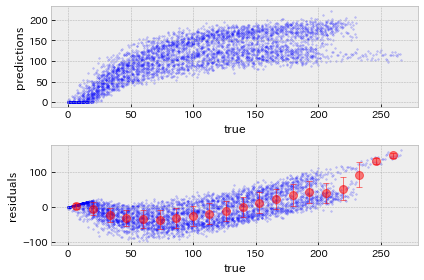

In [58]:
preds = pd.DataFrame({"preds": predictions, "true": y_val})
preds["residuals"] = preds["true"] - preds["preds"]
plot_residual(preds, scatter=True) 

It seems there are at least two components in true vs predictions plot, which could be handled by more complex model or by adding more inputs. Residuals show similar structure.

**evaluate the model with test data**

Text(0, 0.5, 'RUL')

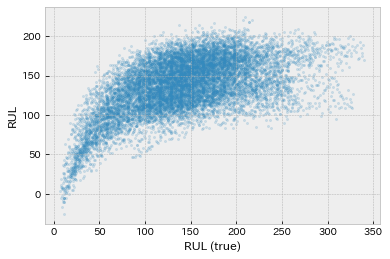

In [59]:
columns = ['os1', 'os2', 'os3', 'T2', 'T24', 'T30', 'T50', 'P2',
           'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR',
           'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']
x_test = test[columns]
y_test = test.rul
predictions = reg_lin.predict(x_test)
plt.figure()
plt.scatter(y_test, predictions, s=5, alpha=0.2)
plt.xlabel('RUL (true)')
plt.ylabel('RUL')


2344.3507211839687
0.33139440206183013
0.3260238460377537


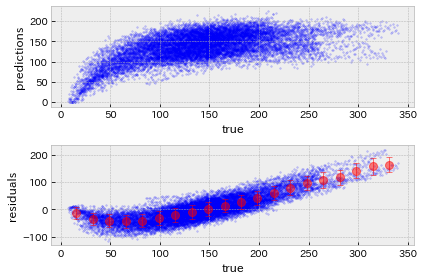

In [60]:
predictions[predictions <= 0] = 1   # fix unphysical predictions

print(mean_squared_error(y_test, predictions))
print(explained_variance_score(y_test, predictions))
print(r2_score(y_test, predictions))

preds = pd.DataFrame({"preds": predictions, "true": y_test})
preds["residuals"] = preds["true"] - preds["preds"]
plot_residual(preds, scatter=True) 

### 3. feature engineering
Usually we pay more attention to deviations from stable operating conditions. Let's take means of the sequences of data at the beginning then use them as references.

In [61]:
window = 20

df = train[train.unit==1].copy()
stable = df[:window].rolling(window).mean()[-1:]
features = df - stable.to_numpy()

for unit in np.arange(2,101):
  df = train[train.unit==unit].copy()
  stable = df[:window].rolling(window).mean()[-1:]
  df = df - stable.to_numpy()
  features = pd.concat([features, df])

features.columns = ['unit', 'time', 'os1', 'os2', 'os3', 'T2_diff', 'T24_diff', 'T30_diff', 'T50_diff', 'P2_diff',
                    'P15_diff', 'P30_diff', 'Nf_diff', 'Nc_diff', 'epr_diff', 'Ps30_diff', 'phi_diff', 'NRf_diff', 'NRc_diff', 'BPR_diff',
                    'farB_diff', 'htBleed_diff', 'Nf_dmd_diff', 'PCNfR_dmd_diff', 'W31_diff', 'W32_diff', 'rul']

features[['unit', 'time', 'rul', 'os1', 'os2', 'os3']] = train[['unit', 'time', 'rul', 'os1', 'os2', 'os3']]
df_train = pd.merge(train, features, on=['unit', 'time', 'rul'])

In [62]:
# training and validation data
x_train, x_val, y_train, y_val = get_train_val(df_train)

# test data
df = test[test.unit==1].copy()
stable = df[:window].rolling(window).mean()[-1:]
features = df - stable.to_numpy()

for unit in np.arange(2,101):
  df = test[test.unit==unit].copy()
  stable = df[:window].rolling(window).mean()[-1:]
  df = df - stable.to_numpy()
  features = pd.concat([features, df])

features.columns = ['unit', 'time', 'os1', 'os2', 'os3', 'T2_diff', 'T24_diff', 'T30_diff', 'T50_diff', 'P2_diff',
                    'P15_diff', 'P30_diff', 'Nf_diff', 'Nc_diff', 'epr_diff', 'Ps30_diff', 'phi_diff', 'NRf_diff', 'NRc_diff', 'BPR_diff',
                    'farB_diff', 'htBleed_diff', 'Nf_dmd_diff', 'PCNfR_dmd_diff', 'W31_diff', 'W32_diff', 'rul']

features[['unit', 'time', 'rul', 'os1', 'os2', 'os3']] = train[['unit', 'time', 'rul', 'os1', 'os2', 'os3']]
df_test = pd.merge(train, features, on=['unit', 'time', 'rul'])
x_test = df_test.drop(['unit', 'time', 'rul'], axis=1)
y_test = df_test.rul

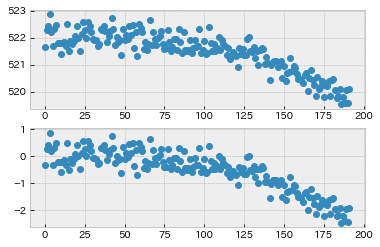

In [63]:
fig, axes = plt.subplots(nrows=2, ncols=1)
df_train[df_train.unit==1]['phi'].plot(marker='o', linewidth=0, ax=axes[0])
df_train[df_train.unit==1]['phi_diff'].plot(marker='o', linewidth=0, ax=axes[1])

#### Linear regression

Text(0, 0.5, 'RUL')

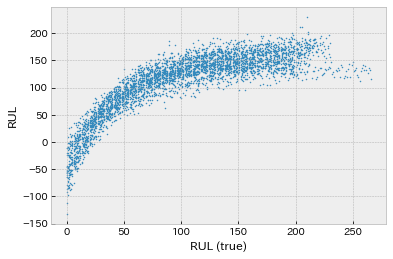

In [30]:
reg_lin = LinearRegression()
reg_lin.fit(x_train, y_train)
predictions = reg_lin.predict(x_val)

plt.figure()
plt.scatter(y_val, predictions, s=1)
plt.xlabel('RUL (true)')
plt.ylabel('RUL')

1190.7897627154111
0.7082524126625243
0.6836840119764578


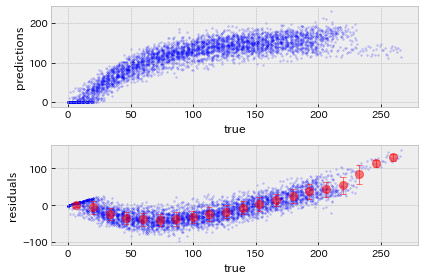

In [31]:
predictions[predictions <= 0] = 1

print(mean_squared_error(y_val, predictions))
print(explained_variance_score(y_val, predictions))
print(r2_score(y_val, predictions))
preds = pd.DataFrame({"preds": predictions, "true": y_val})
preds["residuals"] = preds["true"] - preds["preds"]
plot_residual(preds, scatter=True) 

**evaluate the model with test data**

Text(0, 0.5, 'RUL')

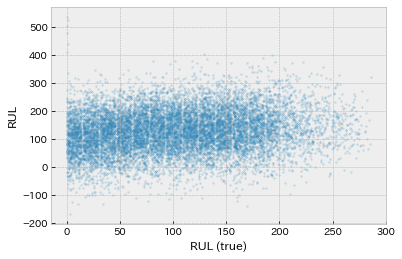

In [32]:
predictions = reg_lin.predict(x_test)
plt.figure()
plt.scatter(y_test, predictions, s=3, alpha=0.2)
plt.xlabel('RUL (true)')
plt.ylabel('RUL')

8258.729767317076
-0.8892625214267655
-1.0780468459125934


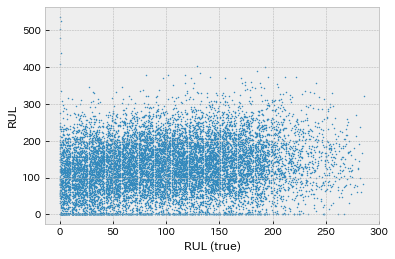

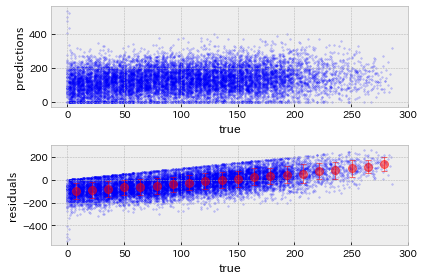

In [34]:
predictions[predictions <= 0] = 1
print(mean_squared_error(y_test, predictions))
print(explained_variance_score(y_test, predictions))
print(r2_score(y_test, predictions))
plt.scatter(y_test, predictions, s=1)
plt.xlabel('RUL (true)')
plt.ylabel('RUL')
preds = pd.DataFrame({"preds": predictions, "true": y_test})
preds["residuals"] = (preds["true"] - preds["preds"])
plot_residual(preds, scatter=True)

**Quite some improvements with feature engineering for train/val data but not for test data**

| model        | data         | RMS               | R2    |
|:-------------|:-------------|:------------------|:------|
| Linear       | val - raw          | 1581.6            | 0.58  |
| Linear       | val - engineered   | 1190.8            | 0.68  |
| Linear       | test - raw          | 2344.4           | 0.33  |
| Linear       | test - engineered   | 8258.7           | -1.08  |

Adding part of engineered data to raw data might help but stick with raw data for now.

### 4. prediction with sophisticated models
#### SVM regression

Text(0, 0.5, 'RUL')

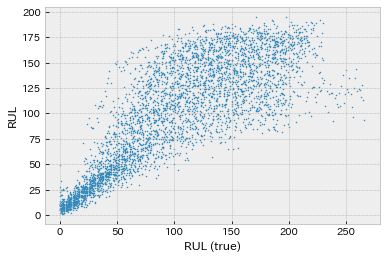

In [35]:
# use raw data
x_train, x_val, y_train, y_val = get_train_val(train)
x_test = test[columns]
y_test = test.rul

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer

steps = [
  ('scaler', RobustScaler()),
  ('svr', SVR()),
]
reg_svr = Pipeline(steps=steps)
reg_svr.get_params()
reg_svr.fit(x_train, y_train)
predictions = reg_svr.predict(x_val)
plt.figure()
plt.scatter(y_val, predictions, s=1)
plt.xlabel('RUL (true)')
plt.ylabel('RUL')


1308.8544712017572
0.654244083426193
0.6523218386651851


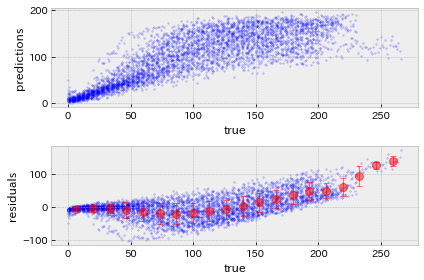

In [36]:
predictions[predictions <= 0] = 1
print(mean_squared_error(y_val, predictions))
print(explained_variance_score(y_val, predictions))
print(r2_score(y_val, predictions))
preds = pd.DataFrame({"preds": predictions, "true": y_val})
preds["residuals"] = (preds["true"] - preds["preds"])
plot_residual(preds, scatter=True) 

2196.2004803779478
0.39261007860701824
0.36861548072993633


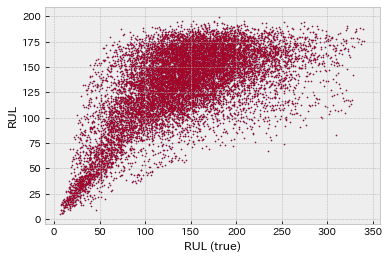

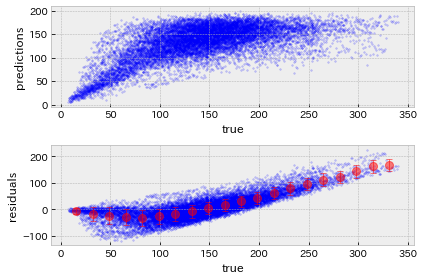

In [37]:
predictions = reg_svr.predict(x_test)
plt.scatter(y_test, predictions, s=1)
plt.xlabel('RUL (true)')
plt.ylabel('RUL')

predictions[predictions <= 0] = 1
print(mean_squared_error(y_test, predictions))
print(explained_variance_score(y_test, predictions))
print(r2_score(y_test, predictions))
plt.scatter(y_test, predictions, s=1)
plt.xlabel('RUL (true)')
plt.ylabel('RUL')
preds = pd.DataFrame({"preds": predictions, "true": y_test})
preds["residuals"] = (preds["true"] - preds["preds"])
plot_residual(preds, scatter=True) 

#### xgboost

1564.2920487441218
0.5863473563307673
0.5844685599013472


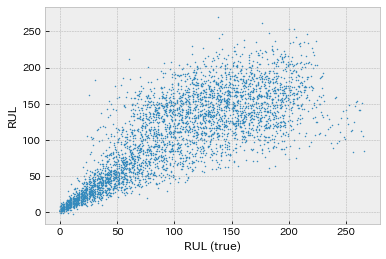

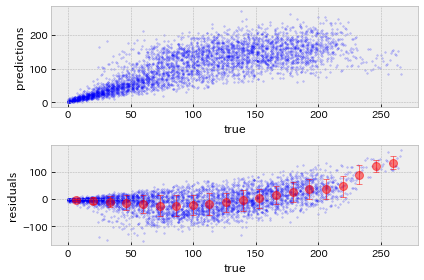

In [42]:
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

steps = [
    ("scaler", RobustScaler()),
    ("xgb", XGBRegressor()),
  ]
reg_xgb = Pipeline(steps=steps)
reg_xgb.get_params() 
reg_xgb.fit(x_train, y_train)

predictions = reg_xgb.predict(x_val)
plt.figure()
plt.scatter(y_val, predictions, s=1)
plt.xlabel('RUL (true)')
plt.ylabel('RUL')

predictions[predictions <= 0] = 1
print(mean_squared_error(y_val, predictions))
print(explained_variance_score(y_val, predictions))
print(r2_score(y_val, predictions))
preds = pd.DataFrame({"preds": predictions, "true": y_val})
preds["residuals"] = (preds["true"] - preds["preds"])
plot_residual(preds, scatter=True) 

2428.533640046316
0.3018530106644698
0.3018221430368022


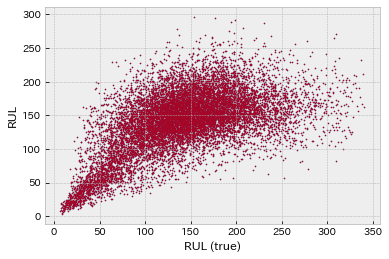

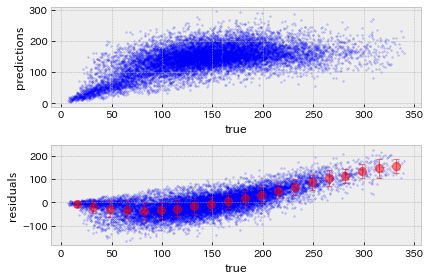

In [43]:
predictions = reg_xgb.predict(x_test)
plt.scatter(y_test, predictions, s=1)
plt.xlabel('RUL (true)')
plt.ylabel('RUL')

predictions[predictions <= 0] = 1
print(mean_squared_error(y_test, predictions))
print(explained_variance_score(y_test, predictions))
print(r2_score(y_test, predictions))
plt.scatter(y_test, predictions, s=1)
plt.xlabel('RUL (true)')
plt.ylabel('RUL')
preds = pd.DataFrame({"preds": predictions, "true": y_test})
preds["residuals"] = (preds["true"] - preds["preds"])
plot_residual(preds, scatter=True) 

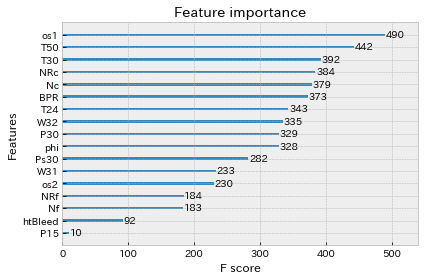

In [44]:
reg_xgb['xgb'].get_booster().feature_names = x_train.columns.tolist()
plot_importance(reg_xgb['xgb'], max_num_features=30)
plt.tight_layout()

### 5. hyper-parameter tuning
#### Randomized Search


Pipeline(memory=None,
         steps=[('scaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('xgb',
                 XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
                              colsample_bynode=1, colsample_bytree=0.8,
                              gamma=0.01, gpu_id=-1, importance_type='gain',
                              interaction_constraints=None, learning_rate=0.1,
                              max_delta_step=0, max_depth=9, min_child_weight=3,
                              missing=nan, monotone_constraints=None,
                              n_estimators=2000, n_jobs=-1, num_parallel_tree=1,
                              objective='reg:squarederror', random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=0.4, tree_method=None,
                            

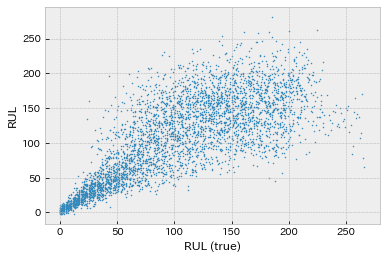

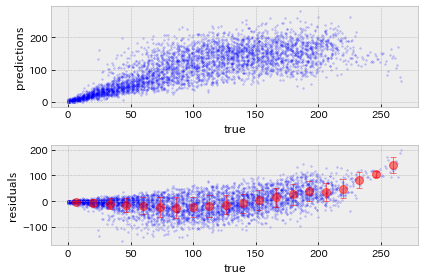

In [47]:
class uniform_random_from_array():
  """ generate random numbers from given array """
  def __init__(self, array=[]):
    self.array = array

  def rvs(self, size=None, random_state=None):
    if size is None:
      return np.random.choice(self.array)
    else:
      return np.random.choice(self.array, size=size)

metric = make_scorer(mean_squared_error, greater_is_better=False)
cv = [(slice(None), slice(None))]
param_random = {
  'xgb__n_estimators': uniform_random_from_array([100, 200, 500, 1000, 2000]),
  'xgb__learning_rate': uniform_random_from_array([0.01, 0.02, 0.05, 0.1, 0.2]),
  'xgb__gamma': uniform_random_from_array([0.0, 0.01, 0.02, 0.05]),
  'xgb__min_child_weight': uniform_random_from_array([1,3,5]),
  'xgb__max_depth': uniform_random_from_array([3,5,7,9]),
  'xgb__subsample': uniform_random_from_array([0.4, 0.6, 0.8, 1.0]),
  'xgb__colsample_bytree': uniform_random_from_array([0.4, 0.6, 0.8, 1.0]),
  'xgb__n_jobs': uniform_random_from_array([-1]),
  }

np.random.seed(0)
reg_xgb = Pipeline(steps=steps)
gs_xgb = RandomizedSearchCV(reg_xgb, n_iter=100, param_distributions=param_random, scoring=metric, cv=cv, n_jobs=-1, random_state=13)
gs_xgb.fit(x_train, y_train)

print(gs_xgb.best_estimator_)
print(gs_xgb.best_params_)

predictions = gs_xgb.predict(x_val)
plt.scatter(y_val, predictions, s=1)
plt.xlabel('RUL (true)')
plt.ylabel('RUL')

predictions[predictions <= 0] = 1
print(mean_squared_error(y_val, predictions))
print(explained_variance_score(y_val, predictions))
print(r2_score(y_val, predictions))
preds = pd.DataFrame({"preds": predictions, "true": y_val})
preds["residuals"] = (preds["true"] - preds["preds"])
plot_residual(preds, scatter=True) 

2633.4981381660514
0.24291853865619928
0.2428970074360266


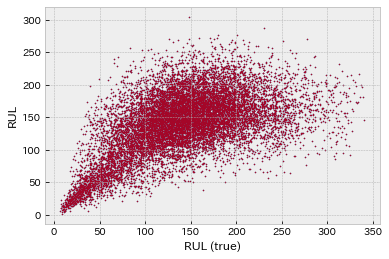

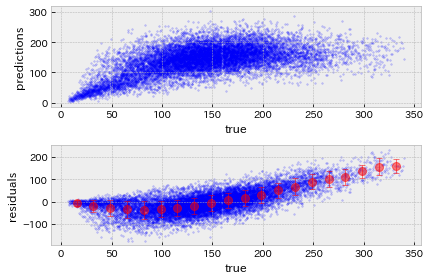

In [48]:
predictions = gs_xgb.predict(x_test)
plt.scatter(y_test, predictions, s=1)
plt.xlabel('RUL (true)')
plt.ylabel('RUL')

predictions[predictions <= 0] = 1
print(mean_squared_error(y_test, predictions))
print(explained_variance_score(y_test, predictions))
print(r2_score(y_test, predictions))
plt.scatter(y_test, predictions, s=1)
plt.xlabel('RUL (true)')
plt.ylabel('RUL')
preds = pd.DataFrame({"preds": predictions, "true": y_test})
preds["residuals"] = (preds["true"] - preds["preds"])
plot_residual(preds, scatter=True) 

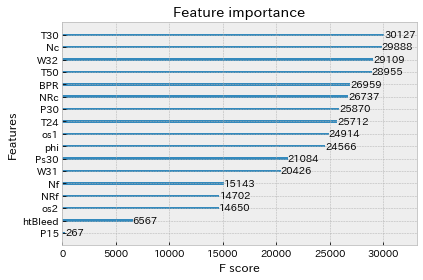

In [51]:
bst = gs_xgb.best_estimator_.named_steps['xgb']
bst.get_booster().feature_names = x_train.columns.tolist()
plot_importance(bst, max_num_features=30)
plt.tight_layout()

In [52]:
from evolutionary_search import EvolutionaryAlgorithmSearchCV

param_grid = {
  'xgb__n_estimators': [100, 200, 500, 1000, 2000],
  'xgb__learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],
  'xgb__gamma': [0.0, 0.01, 0.02, 0.05],
  'xgb__min_child_weight': [1,3,5],
  'xgb__max_depth': [3,5,7,9],
  'xgb__subsample': [0.4, 0.6, 0.8, 1.0],
  'xgb__colsample_bytree': [0.4, 0.6, 0.8, 1.0],
  'xgb__n_jobs': [-1],
  }

np.random.seed(0)
reg_xgb = Pipeline(steps=steps)
ga_xgb = EvolutionaryAlgorithmSearchCV(estimator=reg_xgb, params=param_grid, scoring=metric, cv=2,
                                       verbose=1, population_size=50, gene_mutation_prob=0.10,
                                       gene_crossover_prob=0.5, tournament_size=3, generations_number=5, n_jobs=3)
ga_xgb.fit(x_train, y_train)

Types [1, 2, 2, 1, 1, 2, 2, 1] and maxint [4, 4, 3, 2, 3, 3, 3, 0] detected


/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


--- Evolve in 19200 possible combinations ---
gen	nevals	avg     	min     	max     	std    
0  	50    	-2214.74	-4088.68	-1968.94	404.891
1  	28    	-2049.85	-2258.21	-1968.94	83.5448
2  	28    	-2007.52	-2322.27	-1966.21	74.1359
3  	34    	-2051.74	-4059.1 	-1964.27	305.971
4  	33    	-2036.85	-4055.22	-1957.05	297.704
5  	35    	-2069.08	-4058.18	-1950.87	409.953
Best individual is: {'xgb__n_estimators': 500, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__min_child_weight': 5, 'xgb__max_depth': 5, 'xgb__subsample': 0.4, 'xgb__colsample_bytree': 0.4, 'xgb__n_jobs': -1}
with fitness: -1950.8689670648953


### 6. semi-supervised learning
#### DBN - to be continued

In [65]:
import dbn
dbn1 = dbn.DBN(x_train=x_train, y_train=y_train, x_test=x_val, y_test=y_val,
               hidden_layer=[250],
               learning_rate_rbm=0.0005, batch_size_rbm=150, n_epochs_rbm=200, verbose_rbm=0, random_seed_rbm=500,
               activation_function_nn='linear', learning_rate_nn=0.005, batch_size_nn=150, n_epochs_nn=500, verbose_nn=0,
               decay_rate=0)

dbn1.pretraining()
dbn1.finetuning()
dbn1.predict(x_val)

Using TensorFlow backend.


DBN Layer 1 Pre-training
Pre-training finish.
Fine-tuning start.
Fine-tuning finish.
4047/4047 [==============================] - 0s 39us/step


array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)